# TF-MoDISco on the Nanog GkmExplain Scores

This notebook demonstrates running TF-MoDISco on importance scores obtained from GkmExplain on Nanog ChIP-seq data in H1ESCs. See [this notebook](https://github.com/kundajelab/tfmodisco/blob/de01768331fd63df6cb9d6b9707589928194a1e4/examples/H1ESC_Nanog_gkmsvm/Nanog_GkmExplain_Generate_Data.ipynb) for how to produce the scores.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os

3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]


## Grab the input data

In [3]:
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz -O positives_test.fa.gz
!gunzip -f positives_test.fa.gz 
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz -O gkmexplain_positives_hypimpscores.txt.gz
!gunzip -f gkmexplain_positives_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_dnshuff_hypimpscores.txt.gz -O gkmexplain_dnshuff_hypimpscores.txt.gz
!gunzip -f gkmexplain_dnshuff_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/dnshuff_seqs.fa.gz -O dnshuff_seqs.fa.gz
!gunzip -f dnshuff_seqs.fa.gz

--2021-03-07 16:16:22--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75038 (73K) [application/octet-stream]
Saving to: ‘positives_test.fa.gz’

positives_test.fa.g 100%[===================>]  73.28K  --.-KB/s    in 0.07s   

2021-03-07 16:16:23 (1.10 MB/s) - ‘positives_test.fa.gz’ saved [75038/75038]

--2021-03-07 16:16:23--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)

### Read in the one-hot encoded sequences and scores

In [4]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


def read_in_seqs_and_scores(fa_file, hypimpscores_file):
    seqs = [x.rstrip() for (i,x) in enumerate(open(fa_file)) if i%2==1]
    #filter out any sequences that contain 'N's
    onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                   for x in seqs if ('N' not in x)]
    #read in the hypothetical importance scores,
    # filter out any sequences that contain 'N's
    unnorm_hyp_impscores = [w[0] for w in zip([
        np.array( [[float(z) for z in y.split(",")]
            for y in x.rstrip().split("\t")[2].split(";")])
        for x in open(hypimpscores_file)],seqs)
        if 'N' not in w[1]]
    #in the original GkmExplain paper, a normalization of the
    # importance scores and hypothetical importance scores was
    # proposed, as this was empirically observed to improve
    # the signal-to-noise ratio. Here, I will do a
    # similar-in-spirit normalization that also appears to
    # improve the signal-to-noise ratio, but which is more
    # intuitive and better-motivated than the normalization
    # from the gkmexplain paper (the reason I didn't propose it
    # in that paper is simply that I hadn't considered it).
    #The normalization consists of subtracting the mean
    # hypothetical importance across ACGT at each position such
    # that the sum of the hypothetical importance at each position
    # is 0. The intuition is that this highlights the impact of
    # each base on the output **relative to the other bases that
    # could have been present**. The normalized actual importance
    # is simply the normalized hypothetical importance multiplied
    # by the one-hot encoding.
    hyp_impscores = [x - np.mean(x, axis=-1)[:,None] for x in unnorm_hyp_impscores]
    impscores = [x*y for x,y in zip(hyp_impscores, onehot_data)]
    
    return onehot_data, hyp_impscores, impscores
    

onehot_data, hyp_impscores, impscores = read_in_seqs_and_scores(
    fa_file="positives_test.fa",
    hypimpscores_file="gkmexplain_positives_hypimpscores.txt")
print("Num onehot sequences:",len(onehot_data))

_, _, nulldist_impscores = read_in_seqs_and_scores(
    fa_file="dnshuff_seqs.fa",
    hypimpscores_file="gkmexplain_dnshuff_hypimpscores.txt")
nulldist_perposimp = np.sum(nulldist_impscores, axis=-1)

Num onehot sequences: 960


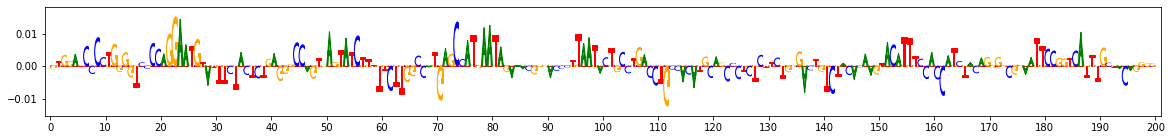

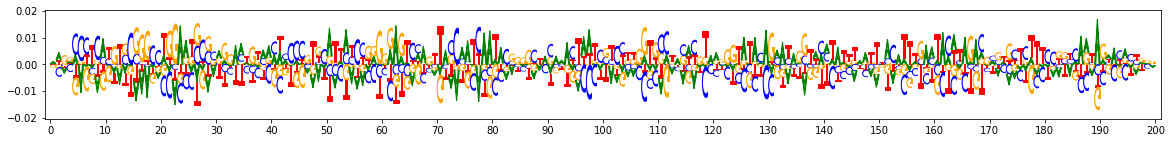

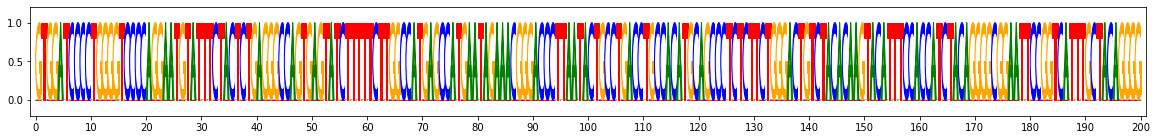

In [5]:
from matplotlib import pyplot as plt
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(hyp_impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=10)


## Run TF-MoDISco

To demonstrate customization, the code below has the following modifications from the default settings:
- An empirical null distribution is supplied for per-position importance scores using the argument `null_per_pos_scores`
- `target_seqlet_fdr` controls the noisiness of the seqlets. For a particular task, importance scores are first smoothed with a window of size `sliding_window_size` (default value of 21 at the time of writing), and the FDR for scores in sliding windows is estimated using the supplied empirical null distribution. This is used to set a threshold on sliding windows that can go on to form seqlets. Note: if the number of sliding windows that pass the FDR threshold is smaller than `min_passing_windows_frac` (default value 0.03 at the time of writing) or larger than `max_passing_windows_frac` (default value of 0.2 at the time of writing), the threshold will be adjusted.
- (new in version 0.5.6.0) MEME is run on the seqlets to find 10 motifs, and the significant motifs are used to initialize TF-MoDISco's Leiden clustering. This initialization is handled by the initclusterer_factory argument.
- The `final_min_cluster_size` is set to 20 rather than the default of 30. The `final_min_cluster_size` determines the minimum support needed (in terms of number of seqlets) for a cluster to be displayed. It was lowered here to potentially enable better comparison to the MEME results, as the MEME motifs can sometimes have very few seqlets.

TF-MoDISco is using the TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term
MEMORY 0.364429312
On task task0
Computing windowed sums on original
Generating null dist
Computing threshold


TF-MoDISco is using the TensorFlow backend.


For increasing = True , the minimum IR precision was 0.28762191141268867 occurring at 1.1961500000490233e-06 implying a frac_neg of 0.40374895862260485
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.4829015187051677 occurring at -5.614999999965353e-07 implying a frac_neg of 0.9338676019623297
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -0.21752344639999993  and  0.15626441020500015 with frac passing 0.07338541666666666
Final raw thresholds are -0.21752344639999993  and  0.15626441020500015
Final transformed thresholds are -0.9723900462962963  and  0.9213773148148148


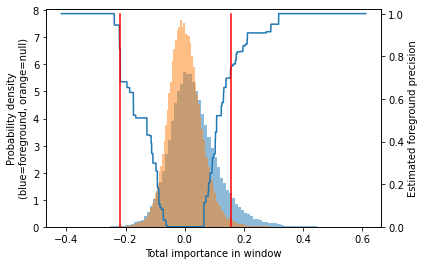

Got 923 coords
After resolving overlaps, got 923 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9212773148148148
MEMORY 0.441683968
923 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [903]
Idx to activities:  {0: '1'}
MEMORY 0.441761792
On metacluster 0
Metacluster size 903
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
Running MEME
Command: meme meme_out/metacluster0/inp_seqlets.fa -dna -mod zoops -nmotifs 10 -p 4 -minw 6 -maxw 50 -objfun classic -revcomp -markov_order 0 -oc meme_out/metacluster0
Duration of MEME: 414.3079266548157 seconds
Skipping motif AGCAGGSYYCWSAG as e-value 1.5 does not meet threshold of 0.05
Skipping motif RAKSCCTTTGAAR as e-value 200.0 does not meet threshold of 0.05
Skipping motif GAATAGAYKGTRAATGTTTCT as e-value 260000.0 does not meet threshold of 0.05
Skipping motif KGCCAGSMAKG as e-value 670000.0 does not meet threshold of 0.

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 896 out of 903 | elapsed:   15.8s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 903 out of 903 | elapsed:   15.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 903 out of 903 | elapsed:   17.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 903 out of 903 | elapsed:    2.2s finished


Constructing csr matrix...
csr matrix made in 0.21742701530456543 s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 903 out of 903 | elapsed:    2.2s finished


Constructing csr matrix...
csr matrix made in 0.21636605262756348 s
Finished embedding computation in 38.14 s
MEMORY 0.765579264
Starting affinity matrix computations
MEMORY 0.765579264
Batching in slices of size 903


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]

Finished affinity matrix computations in 2.46 s
MEMORY 0.798294016
(Round 1) Computed coarse affmat
MEMORY 0.798294016
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.798294016


Launching nearest neighbors affmat calculation job
MEMORY 0.8010752
Parallel runs completed
MEMORY 0.867713024
Job completed in: 19.94 s
MEMORY 0.867713024
Launching nearest neighbors affmat calculation job
MEMORY 0.867713024
Parallel runs completed
MEMORY 0.878665728
Job completed in: 18.48 s
MEMORY 0.878665728
(Round 1) Computed affinity matrix on nearest neighbors in 38.68 s
MEMORY 0.891572224
Filtered down to 893 of 903
(Round 1) Retained 893 rows out of 903 after filtering
MEMORY 0.891777024
(Round 1) Computing density adapted affmat
MEMORY 0.891777024
[t-SNE] Computed conditional probabilities for sample 893 / 893
[t-SNE] Mean sigma: 0.235491
(Round 1) Computing clustering
MEMORY 0.89298944
Beginning preprocessing + Leiden


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s


Quality: 0.650615485424479
Quality: 0.6508202170876235
Quality: 0.6514824256206074
Quality: 0.6515780458654592
Quality: 0.6517441330928022
Quality: 0.6517848272673595
Quality: 0.6520603896044888


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s


Got 11 clusters after round 1
Counts:
{2: 160, 4: 62, 5: 32, 0: 250, 1: 229, 9: 6, 7: 26, 3: 88, 8: 7, 6: 31, 10: 2}
MEMORY 0.893124608
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.893124608
Aggregating for cluster 0 with 250 seqlets
MEMORY 0.893124608


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    8.2s finished


Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 19 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 230
Skipped 18 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 229 seqlets
MEMORY 0.893136896
Skipped 3 seqlets that went over the sequence edge during flank expansion
Skipped 2 seqlets that went over the sequence edge during flank expansion
Skipped 22 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 202
Skipped 21 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 2 with 160 seqlets
MEMORY 0.893177856
Skipped 2 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 20 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 137
Skipped 6 seqlets th

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 716 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done 724 out of 724 | elapsed:    9.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  96 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 696 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done 724 out of 724 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 724 out of 724 | elapsed:    1.7s finished


Constructing csr matrix...
csr matrix made in 0.17525291442871094 s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 724 out of 724 | elapsed:    1.7s finished


Constructing csr matrix...
csr matrix made in 0.16708993911743164 s
Finished embedding computation in 23.59 s
MEMORY 0.89737216
Starting affinity matrix computations
MEMORY 0.89737216
Batching in slices of size 724


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

Finished affinity matrix computations in 2.23 s
MEMORY 0.89737216
(Round 2) Computed coarse affmat
MEMORY 0.89737216
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 0.89737216


Launching nearest neighbors affmat calculation job
MEMORY 0.897572864
Parallel runs completed
MEMORY 0.939278336
Job completed in: 25.87 s
MEMORY 0.939278336
Launching nearest neighbors affmat calculation job
MEMORY 0.939278336
Parallel runs completed
MEMORY 0.945770496
Job completed in: 25.57 s
MEMORY 0.945770496
(Round 2) Computed affinity matrix on nearest neighbors in 51.68 s
MEMORY 0.948092928
Not applying filtering for rounds above first round
MEMORY 0.948092928
(Round 2) Computing density adapted affmat
MEMORY 0.948092928
[t-SNE] Computed conditional probabilities for sample 724 / 724
[t-SNE] Mean sigma: 0.240718
(Round 2) Computing clustering
MEMORY 0.951472128
Beginning preprocessing + Leiden


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.3s


Quality: 0.6016673783786702
Quality: 0.6019287331275986
Quality: 0.6020545905542471
Quality: 0.6022152094137132
Quality: 0.602298041423298


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.3s


Quality: 0.6023948271096559
Got 10 clusters after round 2
Counts:
{0: 213, 5: 30, 2: 95, 6: 19, 1: 188, 4: 72, 3: 95, 9: 2, 7: 7, 8: 3}
MEMORY 0.951472128
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.951472128
Aggregating for cluster 0 with 213 seqlets
MEMORY 0.951472128


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.3s finished


Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 3 seqlets that went over sequence edge during flank expansion
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 208
Skipped 22 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 188 seqlets
MEMORY 0.951529472
Skipped 2 seqlets that went over sequence edge during flank expansion
Skipped 2 due to duplicates
Trimming eliminated 0 seqlets out of 184
Skipped 25 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 2 with 95 seqlets
MEMORY 0.951574528
Trimming eliminated 0 seqlets out of 95
Skipped 3 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 3 with 95 seqlets
MEMORY 0.95162368
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 94
Skipped 8 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 4 with 72 seqlets
MEMORY 0.95166873

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 186 out of 186 | elapsed:    0.1s finished


Beginning preprocessing + Leiden


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.8s


Quality: 0.17291258565817857
Quality: 0.17318795135302908
Quality: 0.1736958751816916
Quality: 0.17383382212852458
Quality: 0.1740787410432059
Got subclusters: Counter({0: 38, 1: 35, 2: 35, 3: 27, 4: 26, 5: 16, 6: 9})
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.8s finished


Numbers for each pattern pre-subsample: [38, 35, 35, 27, 26, 16, 9]
Numbers after subsampling: [38, 35, 35, 27, 26, 16, 9]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.19879913330078125 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.18630123138427734 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.19885635375976562 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.1339120864868164 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.13241982460021973 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.09691119194030762 s
Computing sims for pattern 6
Computed sims for pattern 6 in 0.07201600074768066 s
Cluster sizes
[38 35 35 27 26 16  9]
Cross-contamination matrix:
[[1.   0.55 0.78 0.81 0.91 0.83 0.45]
 [0.96 1.   0.9  0.95 1.   0.96 0.66]
 [0.89 0.66 1.   0.87 0.97 0.92 0.57]
 [0.9  0.7  0.86 1.   0.95 0.92 0.56]
 [0.74 0.51 0.73 0.74 1.   0.74 0.36]
 [0.77 0.52 0.75 0.77 0.85 1.   0.39]
 [0.74 0.62

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 159 out of 159 | elapsed:    0.1s finished


Beginning preprocessing + Leiden


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s


Quality: 0.20316158519862834
Quality: 0.20335956243055892
Quality: 0.20382932977433793
Quality: 0.20561700935848487
Quality: 0.2064486410532755
Got subclusters: Counter({0: 45, 1: 38, 2: 37, 3: 22, 4: 17})
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.4s finished


Numbers for each pattern pre-subsample: [45, 38, 37, 22, 17]
Numbers after subsampling: [45, 38, 37, 22, 17]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.148223876953125 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.1408829689025879 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.12390875816345215 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.08779597282409668 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.07214188575744629 s
Cluster sizes
[45 38 37 22 17]
Cross-contamination matrix:
[[1.   0.87 0.76 0.84 0.74]
 [0.5  1.   0.59 0.74 0.48]
 [0.71 0.92 1.   0.88 0.69]
 [0.48 0.76 0.55 1.   0.42]
 [0.74 0.84 0.74 0.74 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.84 0.87 0.85 0.85]
 [0.84 1.   0.87 0.89 0.81]
 [0.87 0.87 1.   0.89 0.84]
 [0.85 0.89 0.89 1.   0.79]
 [0.85 0.81 0.84 0.79 1.  ]]
Collapsing 1 & 3 with crosscontam 0.7384292701029835 and sim 0.891488876343525
Collapsing 2 & 3 with crosscontam

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  92 out of  92 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s


Quality: 0.17843625009017977
Quality: 0.17877727727027967
Got subclusters: Counter({0: 44, 1: 32, 2: 16})
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Numbers for each pattern pre-subsample: [44, 32, 16]
Numbers after subsampling: [44, 32, 16]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.06417512893676758 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.06329488754272461 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.03615212440490723 s
Cluster sizes
[44 32 16]
Cross-contamination matrix:
[[1.   0.61 0.7 ]
 [0.61 1.   0.68]
 [0.73 0.72 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.73 0.82]
 [0.73 1.   0.84]
 [0.82 0.84 1.  ]]
Inspecting pattern 3 for spurious merging
[t-SNE] Computed conditional probabilities for sample 86 / 86
[t-SNE] Mean sigma: 0.534037
Beginning preprocessing + Leiden


[Parallel(n_jobs=4)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  86 out of  86 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s


Quality: 0.17243274773650644
Quality: 0.175813568191199
Quality: 0.17584168174059492
Got subclusters: Counter({0: 44, 1: 31, 2: 11})
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Numbers for each pattern pre-subsample: [44, 31, 11]
Numbers after subsampling: [44, 31, 11]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.0686502456665039 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.061669111251831055 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.03775191307067871 s
Cluster sizes
[44 31 11]
Cross-contamination matrix:
[[1.   0.64 0.82]
 [0.63 1.   0.68]
 [0.66 0.57 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.75 0.81]
 [0.75 1.   0.72]
 [0.81 0.72 1.  ]]
Inspecting pattern 4 for spurious merging
[t-SNE] Computed conditional probabilities for sample 57 / 57
[t-SNE] Mean sigma: 1.014657
Beginning preprocessing + Leiden


[Parallel(n_jobs=4)]: Done  57 out of  57 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s


Quality: 0.05369816131079367
Quality: 0.05391766698841769
Quality: 0.05510532576918827
Quality: 0.05532062557138138
Got subclusters: Counter({0: 24, 1: 19, 2: 14})
On merging iteration 1
Numbers for each pattern pre-subsample: [24, 19, 14]
Numbers after subsampling: [24, 19, 14]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.04250693321228027 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.0309908390045166 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.030703306198120117 s
Cluster sizes
[24 19 14]
Cross-contamination matrix:
[[1.   0.29 0.13]
 [0.95 1.   0.51]
 [0.72 0.62 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.75 0.47]
 [0.75 1.   0.49]
 [0.47 0.49 1.  ]]
Inspecting pattern 5 for spurious merging
Inspecting pattern 6 for spurious merging
Inspecting pattern 7 for spurious merging
Inspecting pattern 8 for spurious merging
Inspecting pattern 9 for spurious merging
Merging on 17 clusters
MEMORY 0.952303616
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.3s finished


Numbers for each pattern pre-subsample: [177, 9, 153, 44, 32, 16, 44, 31, 11, 24, 19, 14, 29, 19, 7, 3, 1]
Numbers after subsampling: [177, 9, 153, 44, 32, 16, 44, 31, 11, 24, 19, 14, 29, 19, 7, 3, 1]
Computing sims for pattern 0
Applying left/right pad of 0 and 6 for (917, 156, 206) with total sequence length 200
Applying left/right pad of 0 and 6 for (917, 156, 206) with total sequence length 200
Computed sims for pattern 0 in 2.5901050567626953 s
Computing sims for pattern 1
Applying left/right pad of 0 and 6 for (917, 156, 206) with total sequence length 200
Applying left/right pad of 0 and 6 for (917, 156, 206) with total sequence length 200
Computed sims for pattern 1 in 0.2138671875 s
Computing sims for pattern 2
Applying left/right pad of 0 and 12 for (917, 162, 212) with total sequence length 200
Applying left/right pad of 0 and 12 for (917, 162, 212) with total sequence length 200
Applying left/right pad of 4 and 0 for (232, -4, 46) with total sequence length 200
Applying lef

Numbers for each pattern pre-subsample: [206, 153, 87, 32, 31, 24, 19, 19, 16, 14, 11, 9, 7, 3, 1]
Numbers after subsampling: [206, 153, 87, 32, 31, 24, 19, 19, 16, 14, 11, 9, 7, 3, 1]
Computing sims for pattern 0
Applying left/right pad of 0 and 9 for (917, 159, 209) with total sequence length 200
Applying left/right pad of 0 and 9 for (917, 159, 209) with total sequence length 200
Applying left/right pad of 1 and 0 for (232, -1, 49) with total sequence length 200
Applying left/right pad of 1 and 0 for (232, -1, 49) with total sequence length 200
Computed sims for pattern 0 in 2.1957528591156006 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.33085203170776367 s
Computing sims for pattern 2
Applying left/right pad of 0 and 6 for (917, 156, 206) with total sequence length 200
Applying left/right pad of 0 and 6 for (917, 156, 206) with total sequence length 200
Computed sims for pattern 2 in 0.9995112419128418 s
Computing sims for pattern 3
Computed sims for pattern 3 in

Performing seqlet reassignment
MEMORY 0.952778752
Cross contin jaccard time taken: 0.04 s
Cross contin jaccard time taken: 0.04 s
Skipped 1 due to duplicates
Dropped 18 not passing min_similariy
Skipped 1 due to duplicates
Dropped 8 not passing min_similariy
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over sequence edge during flank expansion
Skipped 2 due to duplicates
Dropped 4 not passing min_similariy
Dropped 5 not passing min_similariy
Dropped 4 not passing min_similariy
Dropped 14 not passing min_similariy
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 2 seqlets that went over the sequence edge during flank expansion
Got 6 patterns after reassignment
MEMORY 0.954368
Total time taken is 252.19s
MEMORY 0.954368
Applying subclustering to the final motifs
On pattern 0


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 190 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed:    0.2s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 216 samples in 0.003s...
[t-SNE] Computed neighbors for 216 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 216 / 216
[t-SNE] Mean sigma: 0.336752
[t-SNE] Computed conditional probabilities in 0.013s
[t-SNE] Iteration 50: error = 64.5359344, gradient norm = 0.5199153 (50 iterations in 0.040s)
[t-SNE] Iteration 100: error = 71.9599991, gradient norm = 0.4192096 (50 iterations in 0.039s)
[t-SNE] Iteration 150: error = 66.8694611, gradient norm = 0.4886041 (50 iterations in 0.037s)
[t-SNE] Iteration 200: error = 68.2107086, gradient norm = 0.4841015 (50 iterations in 0.038s)
[t-SNE] Iteration 250: error = 70.9380035, gradient norm = 0.4231431 (50 iterations in 0.037s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.938004
[t-SNE] Iteration 300: error = 1.2085900, gradient norm = 0.0065377 (50 iterations in 0.042s)
[t-SNE] Iteration 350: error = 0.8303617, gradient norm = 0.0038150 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s


Quality: 0.18566031203339914
Quality: 0.18891515128632183
Quality: 0.18978101489269952
Quality: 0.19105026865321853
Quality: 0.19151146294044394


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 155 out of 155 | elapsed:    0.1s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 53, 1: 45, 2: 40, 3: 32, 4: 31, 5: 15})
On pattern 1
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 155 samples in 0.002s...
[t-SNE] Computed neighbors for 155 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 155 / 155
[t-SNE] Mean sigma: 0.384685
[t-SNE] Computed conditional probabilities in 0.008s
[t-SNE] Iteration 50: error = 61.9190254, gradient norm = 0.4924015 (50 iterations in 0.025s)
[t-SNE] Iteration 100: error = 60.4915771, gradient norm = 0.5143878 (50 iterations in 0.022s)
[t-SNE] Iteration 150: error = 60.1371841, gradient norm = 0.4746795 (50 iterations in 0.031s)
[t-SNE] Iteration 200: error = 62.8098335, gradient norm = 0.4666880 (50 iterations in 0.023s)
[t-SNE] Iteration 250: error = 58.0093765, gradient norm = 0.5311440 (50 iterations in 0.022s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.009377
[t-SNE] Iteration 300: error = 1.0187882, gradient norm = 0.0108964 (50 iteratio

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s


Quality: 0.19041014059322164
Quality: 0.1910011614045859
Quality: 0.19149972902884582
Quality: 0.19169685841211564
Quality: 0.19185570591290935
Quality: 0.19199813308118008


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 102 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 109 out of 109 | elapsed:    0.1s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 40, 1: 35, 2: 32, 3: 24, 4: 14, 5: 10})
On pattern 2
[t-SNE] Computing 108 nearest neighbors...
[t-SNE] Indexed 109 samples in 0.001s...
[t-SNE] Computed neighbors for 109 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 109 / 109
[t-SNE] Mean sigma: 0.449971
[t-SNE] Computed conditional probabilities in 0.004s
[t-SNE] Iteration 50: error = 60.8061142, gradient norm = 0.4933589 (50 iterations in 0.023s)
[t-SNE] Iteration 100: error = 65.3133850, gradient norm = 0.4414453 (50 iterations in 0.017s)
[t-SNE] Iteration 150: error = 60.3182945, gradient norm = 0.4622223 (50 iterations in 0.018s)
[t-SNE] Iteration 200: error = 63.5497131, gradient norm = 0.4697093 (50 iterations in 0.017s)
[t-SNE] Iteration 250: error = 64.7592468, gradient norm = 0.4860304 (50 iterations in 0.018s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.759247
[t-SNE] Iteration 300: error = 1.2684737, gradient norm = 0.0033984 (50 iteratio

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s


Quality: 0.1609626607141816
Quality: 0.16106998738659709


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  32 out of  32 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 43, 1: 39, 2: 22, 3: 5})
On pattern 3
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 32 samples in 0.001s...
[t-SNE] Computed neighbors for 32 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 32 / 32
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 45.0391655, gradient norm = 0.5915984 (50 iterations in 0.010s)
[t-SNE] Iteration 100: error = 41.5301628, gradient norm = 0.6421952 (50 iterations in 0.009s)
[t-SNE] Iteration 150: error = 41.7794266, gradient norm = 0.5639641 (50 iterations in 0.013s)
[t-SNE] Iteration 200: error = 42.5937576, gradient norm = 0.5189880 (50 iterations in 0.013s)
[t-SNE] Iteration 250: error = 48.9627724, gradient norm = 0.4000197 (50 iterations in 0.009s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.962772
[t-SNE] Iteration 300: error = 0.5347084, gradient norm = 0.0006481 (50 iterations in

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s


Quality: 2.0650148258028073e-14


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  34 out of  34 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 32})
On pattern 4
[t-SNE] Computing 33 nearest neighbors...
[t-SNE] Indexed 34 samples in 0.001s...
[t-SNE] Computed neighbors for 34 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 34 / 34
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 45.4729347, gradient norm = 0.3850566 (50 iterations in 0.011s)
[t-SNE] Iteration 100: error = 41.4449654, gradient norm = 0.6544425 (50 iterations in 0.010s)
[t-SNE] Iteration 150: error = 50.2451210, gradient norm = 0.5466656 (50 iterations in 0.009s)
[t-SNE] Iteration 200: error = 48.2897415, gradient norm = 0.4883336 (50 iterations in 0.009s)
[t-SNE] Iteration 250: error = 43.7722931, gradient norm = 0.5463325 (50 iterations in 0.010s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.772293
[t-SNE] Iteration 300: error = 0.5802802, gradient norm = 0.0008364 (50 iterations in 0.010s)
[t-SNE] Ite

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s


Quality: -1.0069722833350307e-13


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  26 out of  26 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 34})
On pattern 5
[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.001s...
[t-SNE] Computed neighbors for 26 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 45.2910004, gradient norm = 0.6804135 (50 iterations in 0.010s)
[t-SNE] Iteration 100: error = 47.0380402, gradient norm = 0.4849893 (50 iterations in 0.010s)
[t-SNE] Iteration 150: error = 45.5909653, gradient norm = 0.6228424 (50 iterations in 0.009s)
[t-SNE] Iteration 200: error = 45.9993820, gradient norm = 0.5189822 (50 iterations in 0.009s)
[t-SNE] Iteration 250: error = 43.9974480, gradient norm = 0.6744986 (50 iterations in 0.009s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.997448
[t-SNE] Iteration 300: error = 0.5115681, gradient norm = 0.0007732 (50 iterations in 0.009s)
[t-SNE] Ite

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s


Quality: 1.7763568394002767e-14
Got subclusters: Counter({0: 26})


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.5s finished


In [6]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
            target_seqlet_fdr=0.25,
            seqlets_to_patterns_factory=
                modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                    initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        meme_command="meme", base_outdir="meme_out",   
                        #max_num_seqlets_to_use specifies the maximum number of seqlets to use
                        # with MEME (this is to speed up MEME in the cases where the number of seqlets is
                        #  very large)
                        max_num_seqlets_to_use=10000,
                        nmotifs=10,
                        n_jobs=4),
                    use_louvain=False,
                    #Adjust trim_to_window_size and initial_flank_to_add
                    # according to how big you expect
                    # the core motif to be; default value is 10
                    #trim_to_window_size=6,
                    #initial_flank_to_add=2,
                    #final_flank_to_add=5,
                    final_min_cluster_size=20
            ),
       )(
    #There is only one task, so we just call this 'task0'
    task_names=["task0"],
    contrib_scores={'task0': impscores},                
    hypothetical_contribs={'task0': hyp_impscores},
    one_hot=onehot_data,
    null_per_pos_scores={'task0': nulldist_perposimp})

## Save and print the results

In [10]:
import h5py
import modisco.util
reload(modisco.util)
! [[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)

Metaclusters heatmap


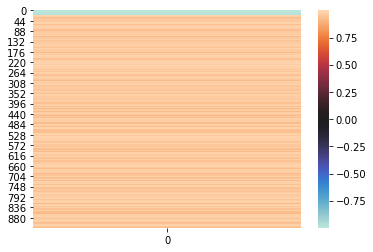

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 216
Hypothetical scores:


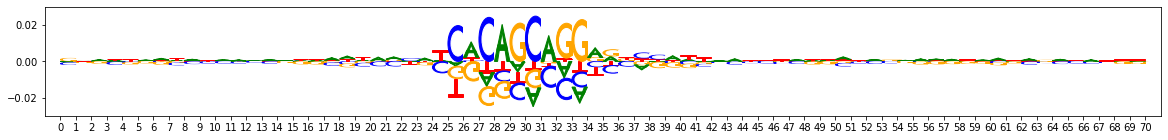

Actual importance scores:


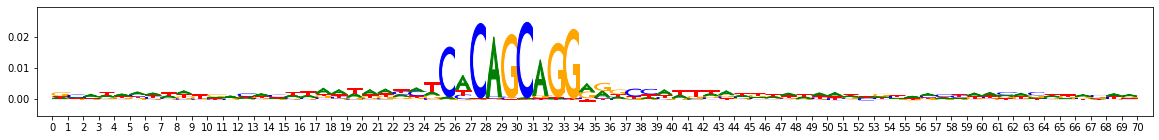

onehot, fwd and rev:


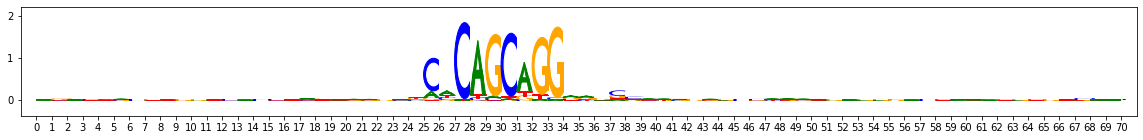

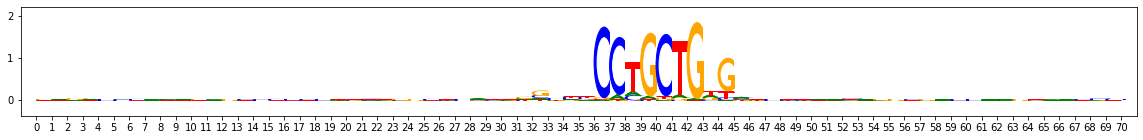

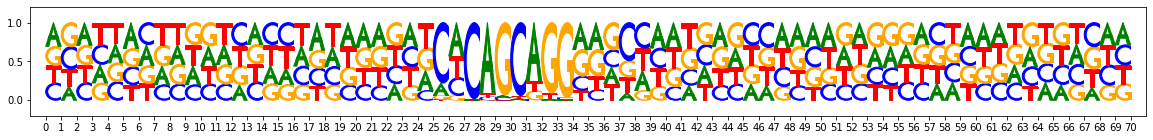

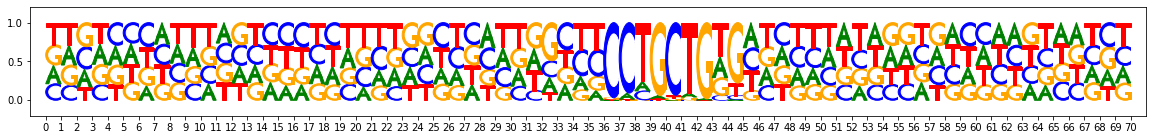

metacluster_0 pattern_1
total seqlets: 155
Hypothetical scores:


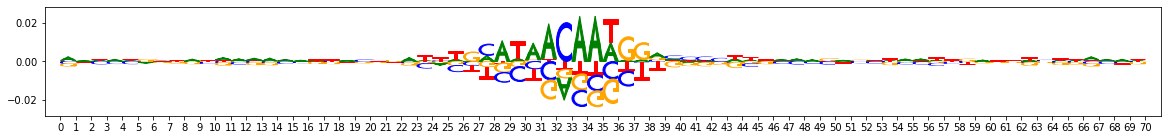

Actual importance scores:


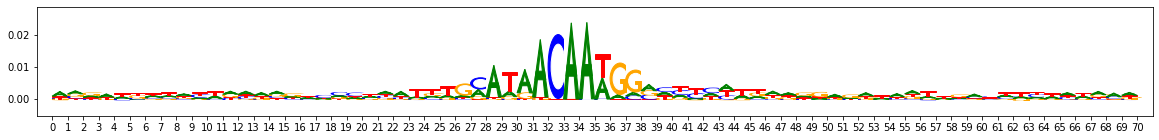

onehot, fwd and rev:


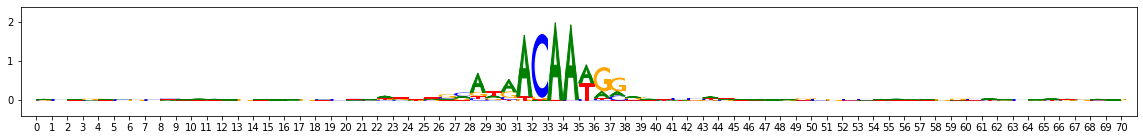

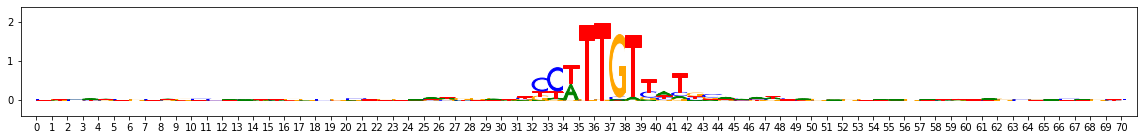

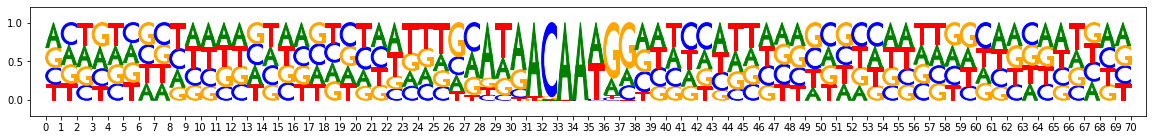

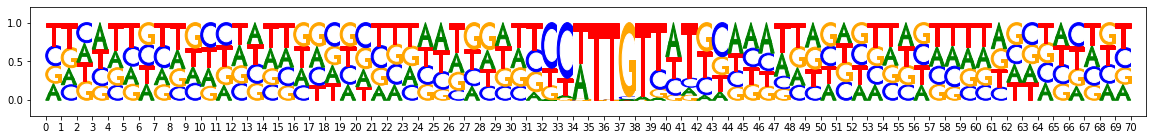

metacluster_0 pattern_2
total seqlets: 109
Hypothetical scores:


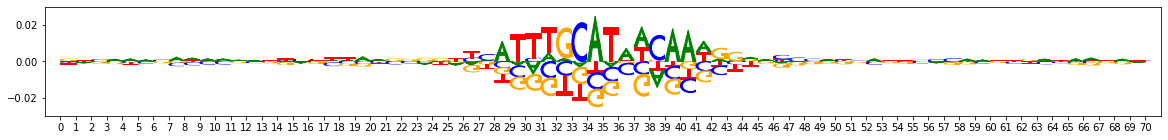

Actual importance scores:


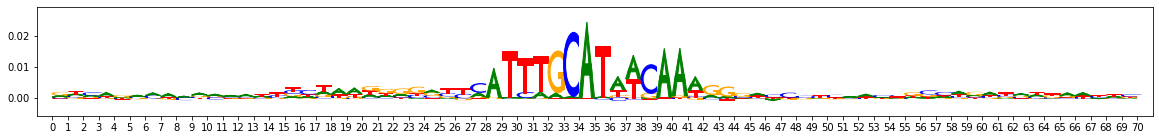

onehot, fwd and rev:


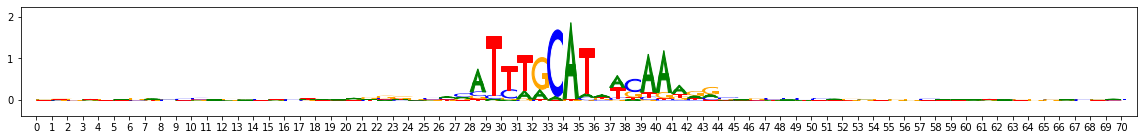

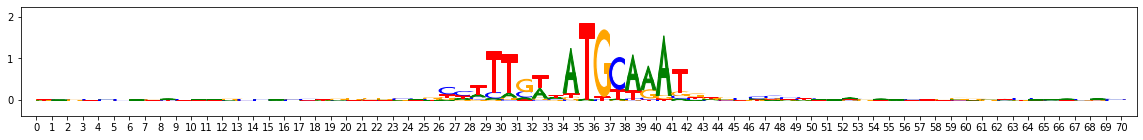

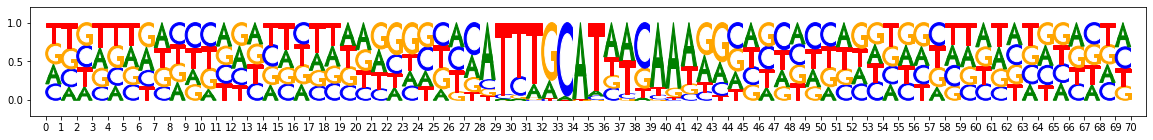

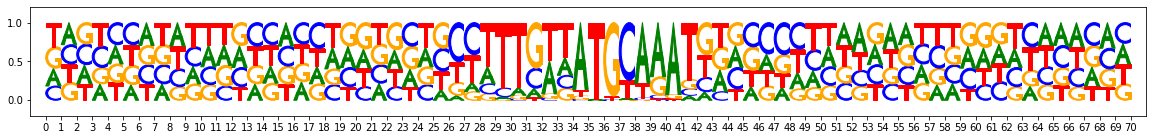

metacluster_0 pattern_3
total seqlets: 32
Hypothetical scores:


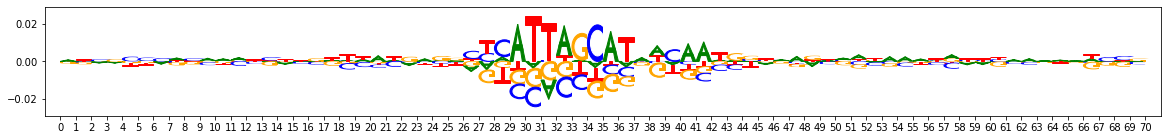

Actual importance scores:


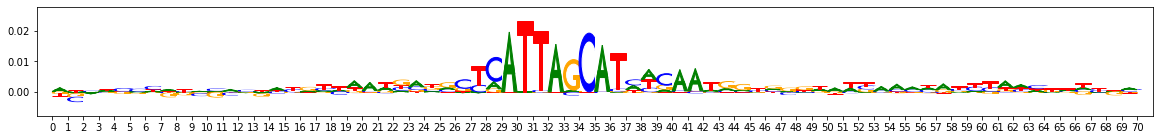

onehot, fwd and rev:


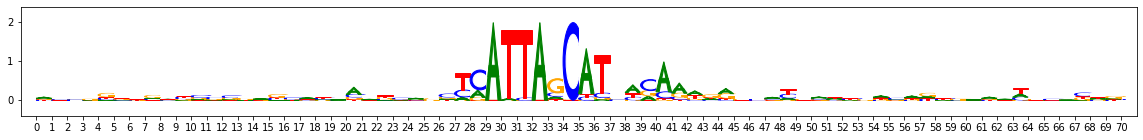

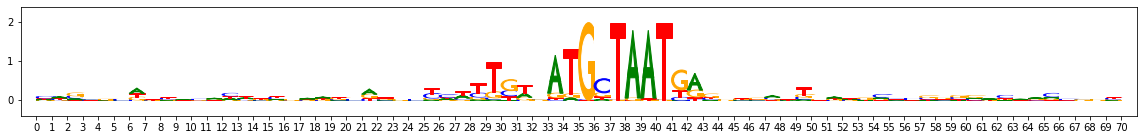

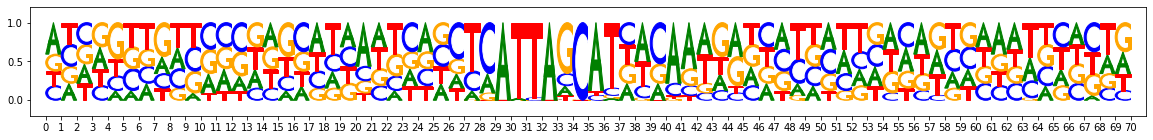

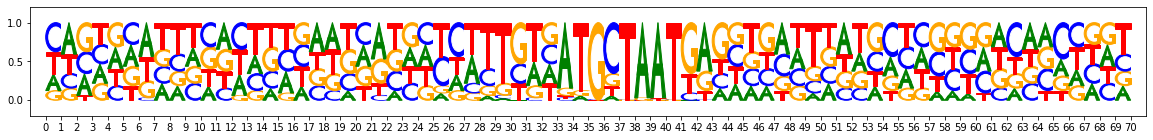

metacluster_0 pattern_4
total seqlets: 34
Hypothetical scores:


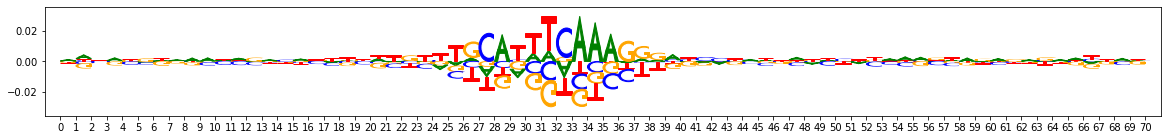

Actual importance scores:


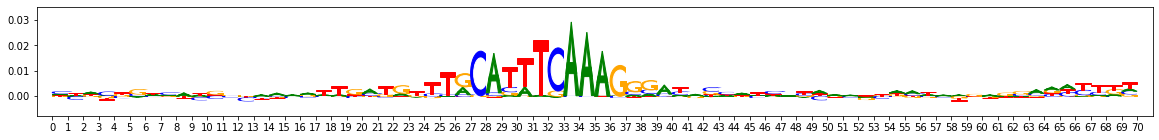

onehot, fwd and rev:


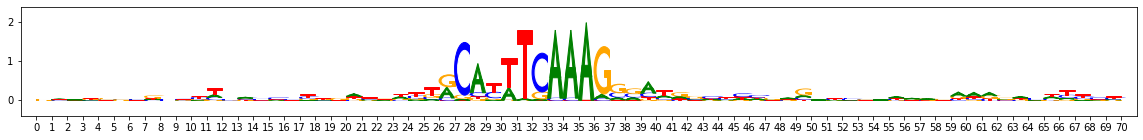

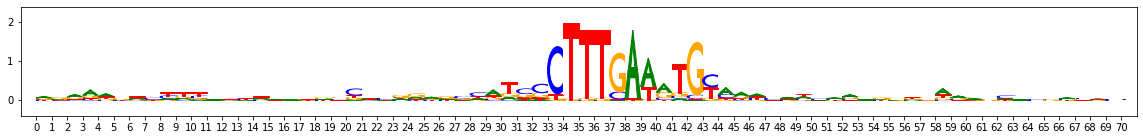

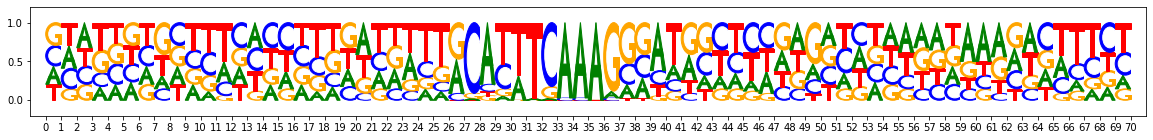

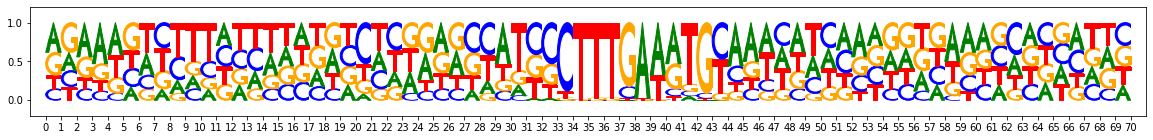

metacluster_0 pattern_5
total seqlets: 26
Hypothetical scores:


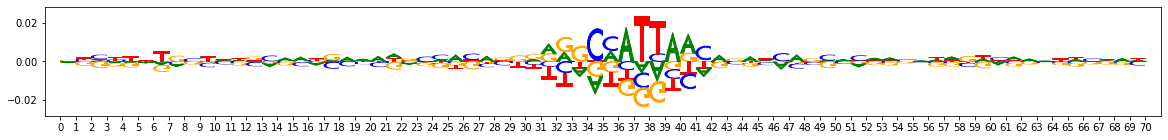

Actual importance scores:


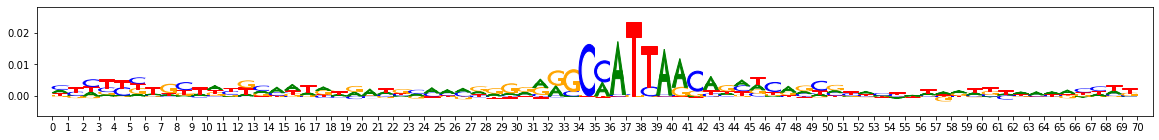

onehot, fwd and rev:


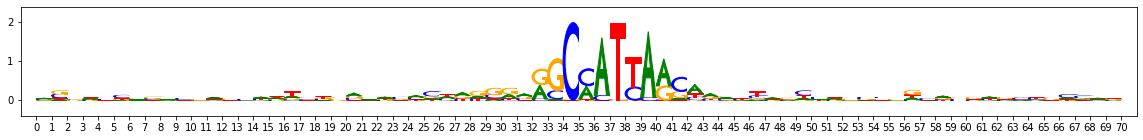

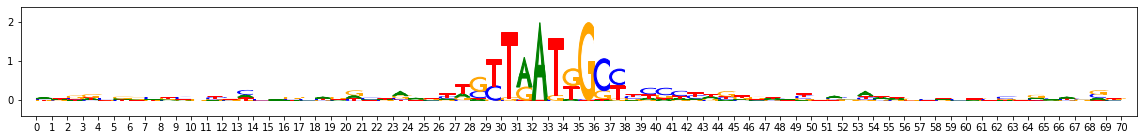

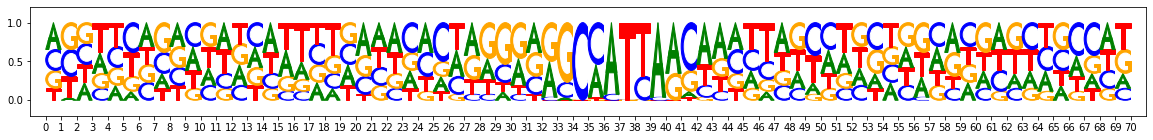

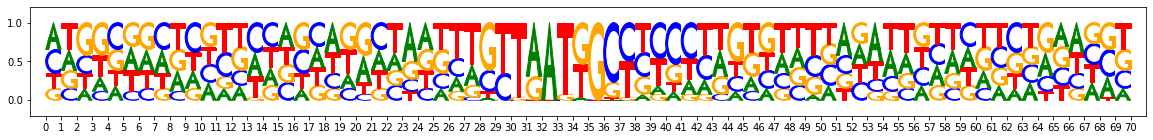

In [11]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background))
        viz_sequence.plot_weights(pattern["sequence"]["fwd"]) 
        viz_sequence.plot_weights(pattern["sequence"]["rev"]) 
        
hdf5_results.close()

### (extra) Visualize the result of using MEME's motifs to initialize the seqlets
This visualizes the intermediate stage where the MEME-derived motifs are used to create an initial set of seqlet clusters. Can be used to get insight into how the MEME-based initialization influenced the TF-MoDISco results

Inspecting meme-based initialization for seqlets in round 1
round 1 MEME-DISco motif number 0
num seqlets mapped to this motif: 205


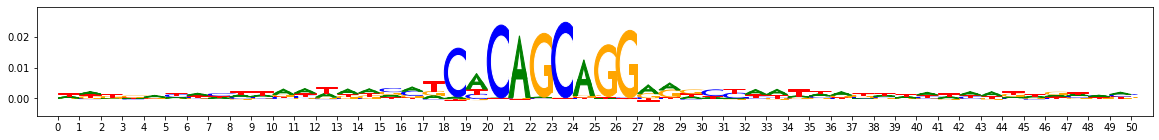

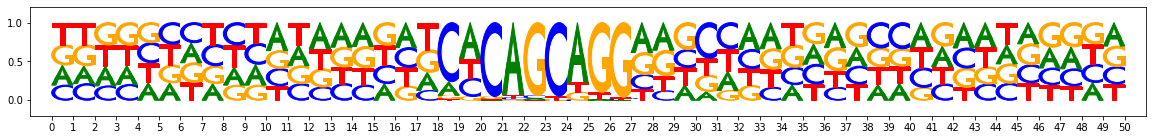

round 1 MEME-DISco motif number 1
num seqlets mapped to this motif: 185


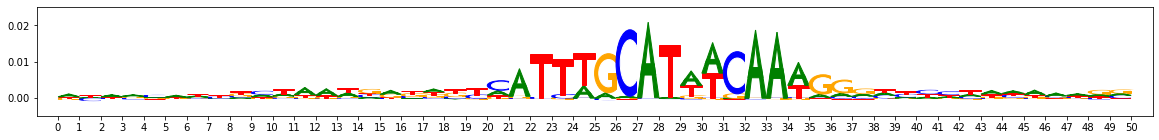

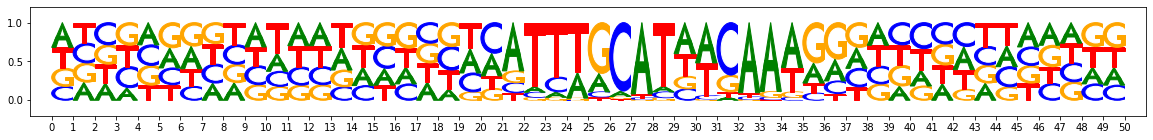

round 1 MEME-DISco motif number 2
num seqlets mapped to this motif: 119


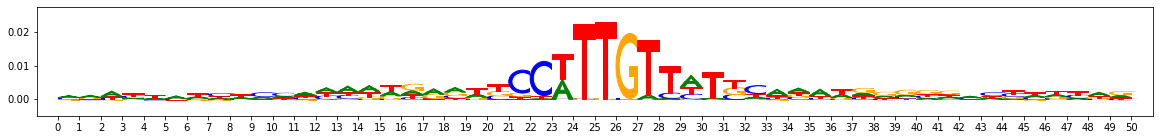

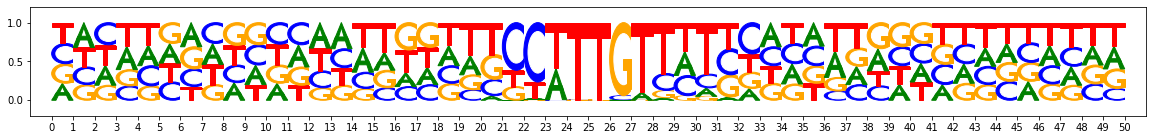

round 1 MEME-DISco motif number 3
num seqlets mapped to this motif: 61


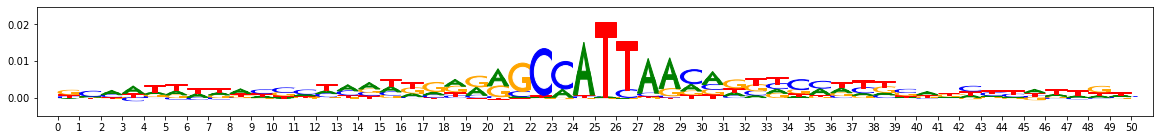

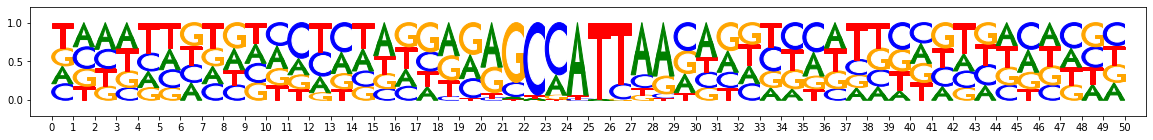

round 1 MEME-DISco motif number 4
num seqlets mapped to this motif: 29


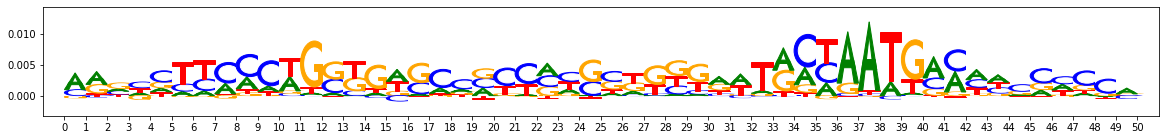

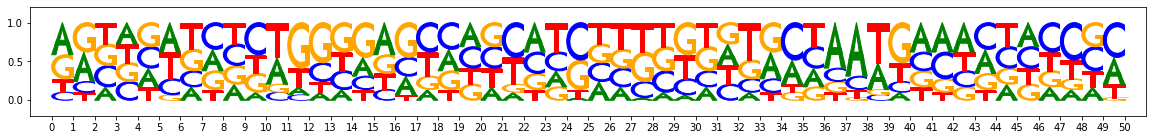

round 1 MEME-DISco motif number 5
num seqlets mapped to this motif: 11


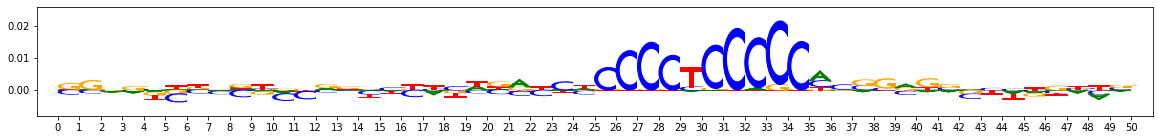

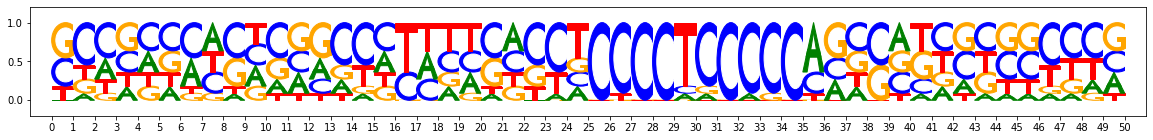

In [12]:
from modisco.visualization import viz_sequence
for round_idx in [1]:
    print("Inspecting meme-based initialization for seqlets in round",round_idx)
    meme_discovered_motifs = (tfmodisco_results
        .metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result
        .each_round_initcluster_motifs[round_idx])
    for idx,motif in enumerate(meme_discovered_motifs):
        print("round",round_idx,"MEME-DISco motif number",idx)
        print("num seqlets mapped to this motif:",len(motif.seqlets))
        viz_sequence.plot_weights(motif["task0_contrib_scores"].fwd)
        viz_sequence.plot_weights(motif["sequence"].fwd)